In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal.metadata.xlsx
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/README.md.txt
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID.metadata.xlsx
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-859.png
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-158.png
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-10121.png
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-1811.png
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-97.png
/kaggle/input/covid19-radiography-database/COVID-19_Radi

 PART -1 EDA

In [5]:
# importing required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from glob import glob
from PIL import Image
import os
import random
import cv2

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPooling2D,MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from tensorflow.keras.metrics import PrecisionAtRecall,Recall

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [8]:
from numpy.random import seed
seed(0)

In [9]:
tf.random.set_seed(0) # so that same random numbers are generated on multiple executions of the code

In [10]:
#loading the data
path='/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/'
diag_code_dict={
    'COVID':0,
    
    'Normal':1,
   
}
diag_title_dict={
    'COVID':'Covid - 19',
 
    'Normal':'Healthy',

}
#modifying the image_ids
# os.path.splitext() method in Python is used to split the path name into a pair root and ext.
# os.path.basename() method in Python is used to get the base name in specified path.
# os.path.join() method in Python join one or more path components intelligently.
# glob module is used to return all file paths that match a specific pattern.

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(path, '*','*.png'))}

# maintaining the covidData dataframe using pandas
covidData= pd.DataFrame.from_dict(imageid_path_dict, orient='index').reset_index() #path and image_id from imageid_path_dict
covidData.columns=['image_id','path']
classes= covidData.image_id.str.split('-').str[0] # taking classes name by splitting image-id
covidData['diag']=classes
covidData['target']=covidData['diag'].map(diag_code_dict.get)
covidData['Class']=covidData['diag'].map(diag_title_dict.get) #mapping the dataframe columns with dictionaries created above
print(" covidData dataframe contents: ",covidData.columns)
print(covidData)

 covidData dataframe contents:  Index(['image_id', 'path', 'diag', 'target', 'Class'], dtype='object')
           image_id                                               path  \
0        Normal-859  /kaggle/input/covid19-radiography-database/COV...   
1        Normal-158  /kaggle/input/covid19-radiography-database/COV...   
2      Normal-10121  /kaggle/input/covid19-radiography-database/COV...   
3       Normal-1811  /kaggle/input/covid19-radiography-database/COV...   
4         Normal-97  /kaggle/input/covid19-radiography-database/COV...   
...             ...                                                ...   
21160    COVID-3283  /kaggle/input/covid19-radiography-database/COV...   
21161    COVID-1855  /kaggle/input/covid19-radiography-database/COV...   
21162    COVID-1273  /kaggle/input/covid19-radiography-database/COV...   
21163    COVID-2233  /kaggle/input/covid19-radiography-database/COV...   
21164    COVID-1918  /kaggle/input/covid19-radiography-database/COV...   

        

In [11]:
covidData[covidData.isnull()]

,image_id,path,diag,target,Class
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
21160,NaN,NaN,NaN,NaN,NaN
21161,NaN,NaN,NaN,NaN,NaN
21162,NaN,NaN,NaN,NaN,NaN
21163,NaN,NaN,NaN,NaN,NaN


In [12]:
samples,feature = covidData.shape
print("Shape of covidData: " ,covidData.shape)
duplicated = covidData.duplicated().sum()
null_values = covidData.isnull().sum().sum()

print('Simple EDA')
print('Number of samples: %d'%(samples))
print('duplicates: %d'%(duplicated))
print('null values: %d' %(null_values))

Shape of covidData:  (21165, 5)
Simple EDA
Number of samples: 21165
duplicates: 0
null values: 14714


Total samples
Healthy       10192
Covid - 19     3616
Name: Class, dtype: int64


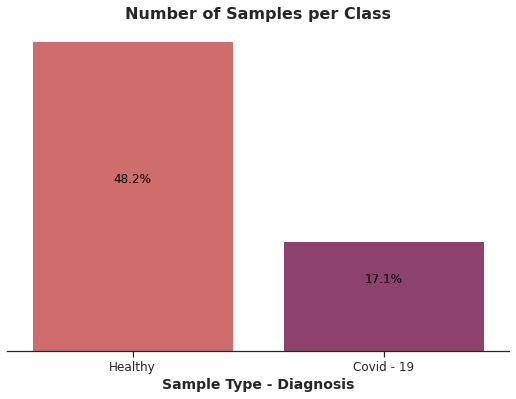

In [13]:
#visualizing samples per class using seaborn and matplotlib libraries
print('Total samples')
print(covidData['Class'].value_counts())


plt.figure(figsize=(9,6))
sns.set(style="ticks", font_scale = 1) #sns.set_style is used to Set the aesthetic style of the plots.
ax = sns.countplot(data = covidData,x='Class',order = covidData['Class'].value_counts().index,palette='flare') 
#sns.countplot for plotting bargraphs
sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Sample Type - Diagnosis',fontsize = 14,weight = 'bold')
ax.set(yticklabels=[])
ax.axes.get_yaxis().set_visible(False) 
plt.title('Number of Samples per Class', fontsize = 16,weight = 'bold');
#plot percentage
for p in ax.patches:
    ax.annotate("%.1f%%" % (100*float(p.get_height()/samples)), (p.get_x() + p.get_width() / 2., abs(p.get_height()/2)),
    ha='center', va='bottom', color='black', xytext=(0, 10),rotation = 'horizontal',
    textcoords='offset points')

In [14]:
# adding image column to the covidData dataframe 
# it includes nparrays of size 75*75 of the images in covidData made using Image library and np.asarray
covidData['image'] = covidData['path'].map(lambda x: np.asarray(Image.open(x).resize((75, 75))))
print(covidData.shape)

(21165, 6)


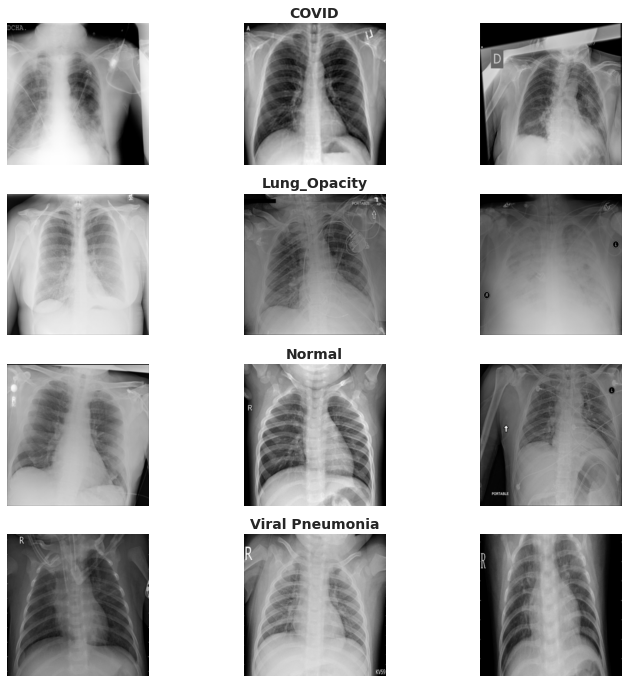

In [15]:
# some image samples from the dataset
n_samples =3

fig, m_axs = plt.subplots(4, n_samples, figsize = (4*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs,covidData.sort_values(['diag']).groupby('diag')):
    n_axs[1].set_title(type_name,fontsize = 14,weight = 'bold')
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

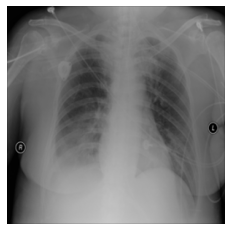

In [16]:
# plotting a random picture
plt.figure()
pic_id = random.randrange(0, samples)
picture = covidData['path'][pic_id]
image = cv2.imread(picture)
plt.imshow(image)
plt.axis('off')
plt.show()

In [17]:
print('shape of the image: {}'.format(image.shape))

shape of the image: (299, 299, 3)


In [18]:
# some info about above image
print('image size {}'.format(image.size))
image.dtype
print('max rgb: {}'.format(image.max()))
print('min rgb: {}'.format(image.min()))
image[0, 0]

image size 268203
max rgb: 202
min rgb: 0


array([2, 2, 2], dtype=uint8)

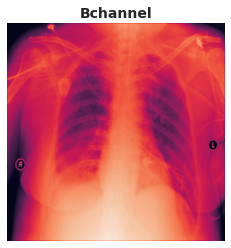

In [19]:
# setting the blue channel of the above image as zero
plt.title('Bchannel', fontsize=14, weight='bold')
plt.imshow(image[:,:,0])
plt.axis('off');
plt.show()

In [20]:
# empty lists to store and append the mean,std deviation, max and min
mean_val = []
std_dev_val = []
max_val = []
min_val = []
# iterating over the image(np-arrrays) column of the covidData dataframe
#for all the samples and calculating mean,std deviation, max and min
for i in range(0, samples):
    mean_val.append(covidData['image'][i].mean())
    std_dev_val.append(np.std(covidData['image'][i])) 
    max_val.append(covidData['image'][i].max())
    min_val.append(covidData['image'][i].min())
#creating the imageEda dataframe and storing the above calculated parameters
imageEDA = covidData.loc[:, ['image', 'Class', 'path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

subt_mean_samples = imageEDA['mean'].mean() - imageEDA['mean']
imageEDA['subt_mean'] = subt_mean_samples
print(imageEDA)

                                                   image       Class  \
0      [[5, 5, 6, 6, 5, 6, 6, 6, 6, 6, 6, 5, 6, 5, 5,...     Healthy   
1      [[64, 85, 96, 97, 115, 138, 130, 133, 141, 112...     Healthy   
2      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     Healthy   
3      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 5, 9, 15, 2...     Healthy   
4      [[96, 111, 136, 152, 170, 163, 160, 176, 175, ...     Healthy   
...                                                  ...         ...   
21160  [[18, 0, 0, 0, 0, 4, 12, 11, 12, 20, 27, 33, 4...  Covid - 19   
21161  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 4, 5, 6, 7,...  Covid - 19   
21162  [[29, 25, 24, 21, 28, 30, 57, 102, 119, 128, 1...  Covid - 19   
21163  [[11, 10, 11, 10, 9, 9, 9, 8, 6, 6, 6, 5, 4, 3...  Covid - 19   
21164  [[84, 44, 10, 5, 4, 3, 3, 4, 5, 5, 5, 5, 4, 4,...  Covid - 19   

                                                    path        mean  \
0      /kaggle/input/covid19-radiography-database/COV...  152.9

plotting the image color distributions

Text(0.5, 1.0, 'Image color mean value distribution')

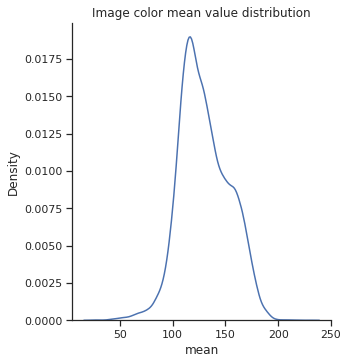

In [21]:

ax = sns.displot(data = imageEDA, x = 'mean', kind="kde")
plt.title('Image color mean value distribution')

Text(0.5, 1.0, 'Image color mean value distribution by class')

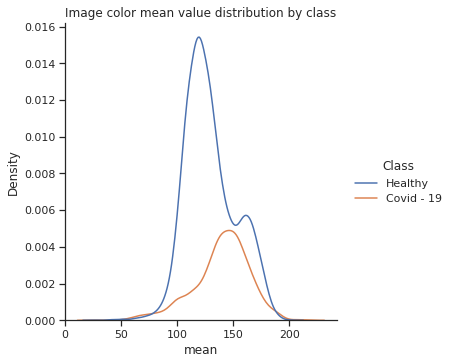

In [22]:
#MEAN
ax = sns.displot(data = imageEDA, x = 'mean', kind="kde", hue='Class')
plt.title('Image color mean value distribution by class')

Text(0.5, 1.0, 'Image color max value distribution by class')

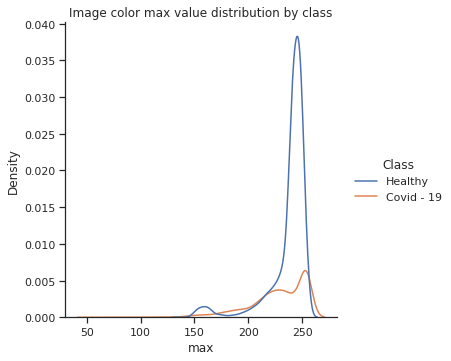

In [23]:
# MAX
ax = sns.displot(data = imageEDA, x = 'max', kind="kde", hue='Class')
plt.title('Image color max value distribution by class')

Text(0.5, 1.0, 'Image color min value distribution by class')

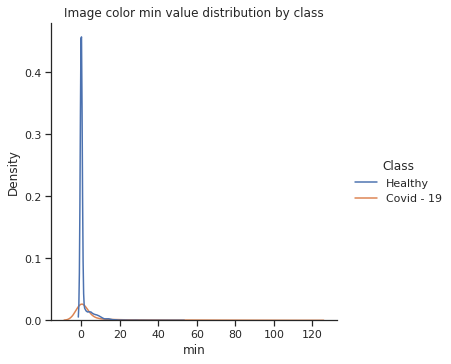

In [24]:
# MIN
sns.displot(data = imageEDA, x = 'min', kind="kde", hue='Class')
plt.title('Image color min value distribution by class')

Text(0.5, 1.0, 'Mean and Standard Deviation of Image Samples')

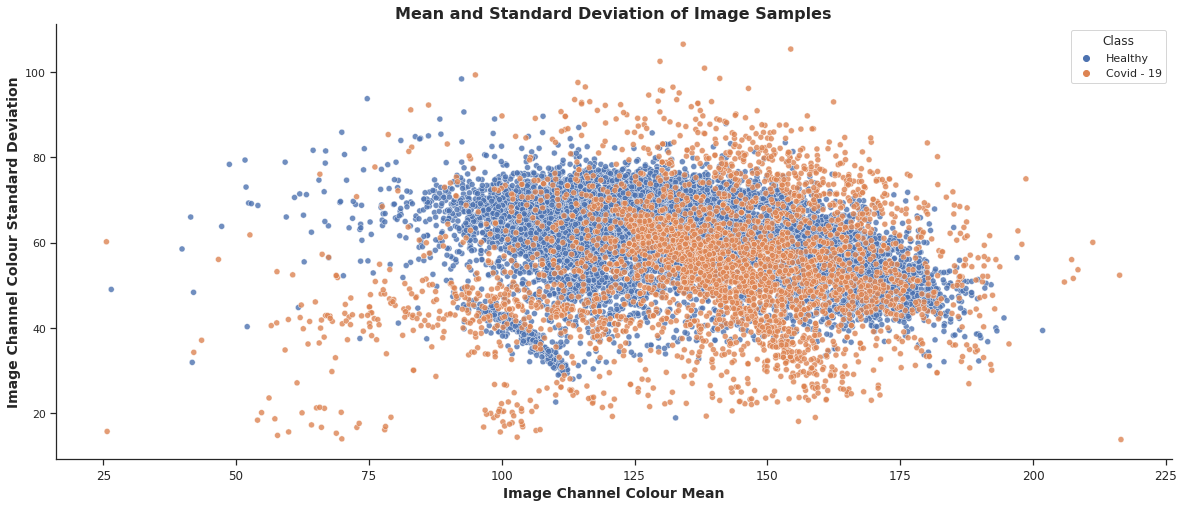

In [25]:
# SCATTERPLOTS FOR HEALTHY AND COVID -19
plt.figure(figsize=(20,8))
sns.set(style="ticks", font_scale = 1)
ax = sns.scatterplot(data=imageEDA, x="mean", y=imageEDA['stedev'], hue = 'Class',alpha=0.8);
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Image Channel Colour Mean',fontsize = 14,weight = 'bold')
ax.set_ylabel('Image Channel Colour Standard Deviation',fontsize = 14,weight = 'bold')
plt.title('Mean and Standard Deviation of Image Samples', fontsize = 16,weight = 'bold')

<Figure size 1440x576 with 0 Axes>

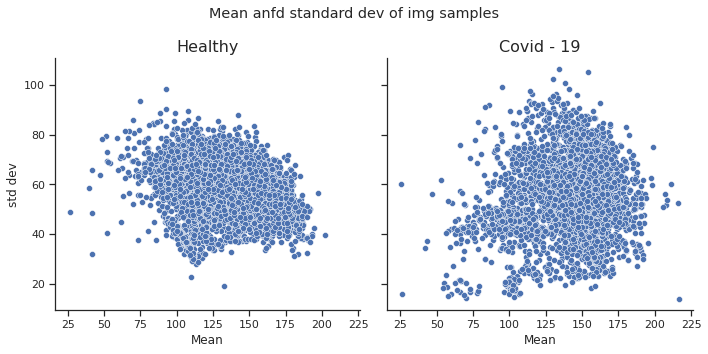

In [26]:
plt.figure(figsize=(20,8));
g = sns.FacetGrid(imageEDA, col="Class", height=5)
g.map_dataframe(sns.scatterplot, x='mean', y='stedev');
g.set_titles(col_template="{col_name}", row_template="{row_name}", size=16)
g.fig.subplots_adjust(top=.7)
g.fig.suptitle('Mean anfd standard dev of img samples')
axes = g.axes.flatten()
axes[0].set_ylabel('std dev')
for ax in axes:
    ax.set_xlabel('Mean')
g.fig.tight_layout()

INFERENCES FROM THE EDA PART
- LOADED THE DATASET AND VIEWED SOME SAMPLES
- CREATED THE COVIDDATA DATAFRAME having columns 'image_id', 'path', 'diag', 'target', 'Class', 'Image'
- CREATED THE IMAGEEDA DATAFRAME AND CALCULATED MIN,MAX,MEAN,STD_DEV FOR COLOR DISTRIBUTIONS IN DATASET IMAGES
-               
-     MEAN   FOR COVID -19 :   140-150
-     MEAN   FOR HEALTHY   :   110-120
- PLOTTED SCATTERPLOTS FOR THE 2 CLASSES


MODEL

In [27]:
path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/'

classes = ["COVID", "Normal"]
num_classes = len(classes)
batch_size = 16

train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip=True, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2)

train_gen = train_datagen.flow_from_directory(directory=path,
                                             target_size=(299, 299),
                                             class_mode='categorical',
                                             subset='training',
                                             shuffle=True, classes=classes,
                                             batch_size=batch_size,
                                             color_mode="grayscale")

test_gen = test_datagen.flow_from_directory(directory=path,
                                             target_size=(299, 299),
                                             class_mode='categorical',
                                             subset='validation',
                                             shuffle=False, classes=classes,
                                             batch_size=batch_size,
                                             color_mode="grayscale")


Found 11047 images belonging to 2 classes.
Found 2761 images belonging to 2 classes.


In [28]:
# creating the model - 6 convolutional layers 
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', padding='Same', input_shape=(299, 299, 1)))
model.add(BatchNormalization())

################

model.add(Conv2D(64, (3,3), activation='relu', padding='Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu', padding='Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), activation='relu', padding='Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#################

model.add(Conv2D(64, (3,3), activation='relu', padding='Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu', padding='Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), activation='relu', padding='Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#################

model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

#Output 
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 299, 299, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 299, 299, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 299, 299, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 299, 299, 64)      256       
_________________________________________________________________
average_pooling2d (AveragePo (None, 149, 149, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 149, 149, 64)      3

In [30]:
#optimizing the model using adam optimizer and crossentropy loss
opt = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[Recall()])

In [31]:
#Model params
epochs=120

#callback
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=100, monitor='val_loss', mode='min')

callbacks_list = [learning_rate_reduction, early_stopping_monitor]

history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen) // batch_size,
                    validation_steps=len(test_gen) // batch_size,
                    validation_data=test_gen, epochs=epochs, callbacks=[callbacks_list])

Epoch 1/120
43/43 [==============================] - 19s 213ms/step - loss: 1.5163 - recall: 0.5126 - val_loss: 0.0930 - val_recall: 1.0000
Epoch 2/120
43/43 [==============================] - 8s 181ms/step - loss: 0.8706 - recall: 0.5682 - val_loss: 0.1172 - val_recall: 1.0000
Epoch 3/120
43/43 [==============================] - 8s 187ms/step - loss: 0.7359 - recall: 0.6376 - val_loss: 0.1719 - val_recall: 1.0000
Epoch 4/120
43/43 [==============================] - 8s 195ms/step - loss: 0.6589 - recall: 0.6720 - val_loss: 0.2046 - val_recall: 1.0000
Epoch 5/120
43/43 [==============================] - 8s 186ms/step - loss: 0.6266 - recall: 0.6944 - val_loss: 0.3879 - val_recall: 0.9812
Epoch 6/120
43/43 [==============================] - 8s 187ms/step - loss: 0.6190 - recall: 0.6890 - val_loss: 0.4998 - val_recall: 0.8313
Epoch 7/120
43/43 [==============================] - 8s 190ms/step - loss: 0.5908 - recall: 0.7107 - val_loss: 0.4696 - val_recall: 0.8000
Epoch 8/120
43/43 [=======

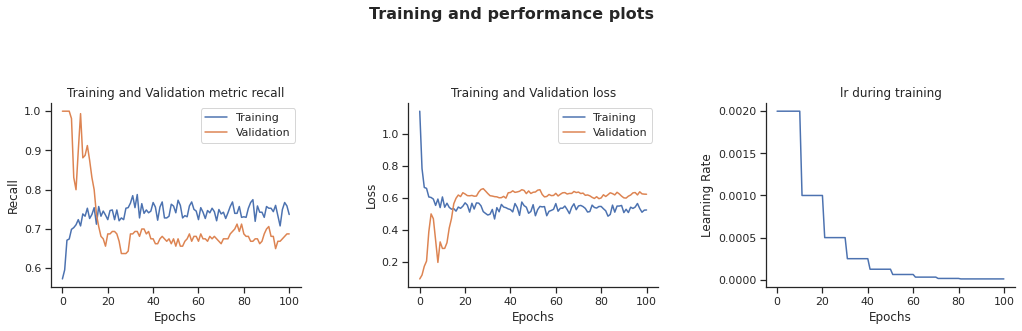

In [33]:
fig, axarr = plt.subplots(1,3, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['recall'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_recall'], ax=axarr[0], label="Validation");
ax.set_ylabel('Recall')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')

ax = sns.lineplot(x = historyDF.index, y = history.history['lr'], ax=axarr[2]);
ax.set_ylabel('Learning Rate')

axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')
axarr[2].set_title('lr during training')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

PART -3 RESULT

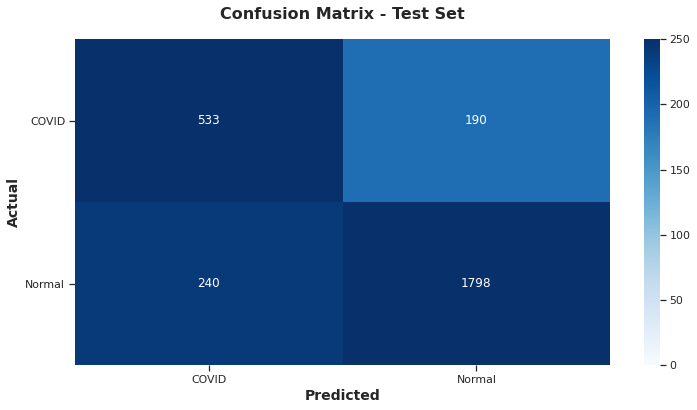

In [34]:

y_pred=model.predict(test_gen)
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

**Overall Results**
Accuracy Result: 84.43%
Precision Result: 79.70%
Recall Result: 80.97%
F-Score Result: 80.29%


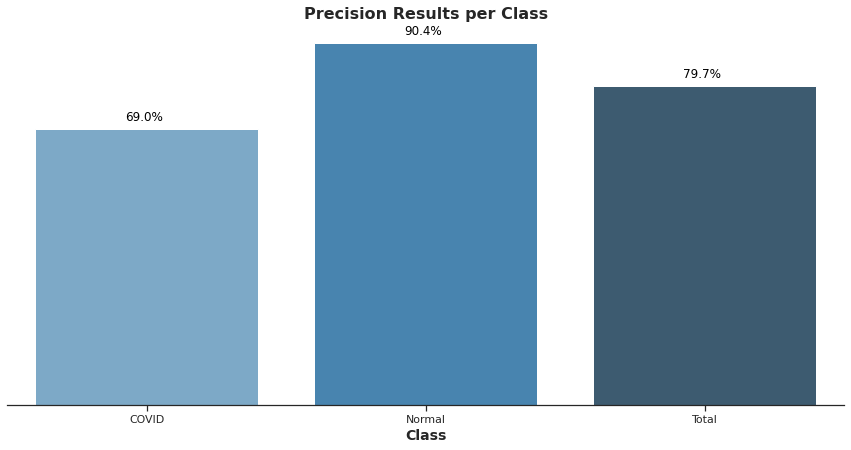

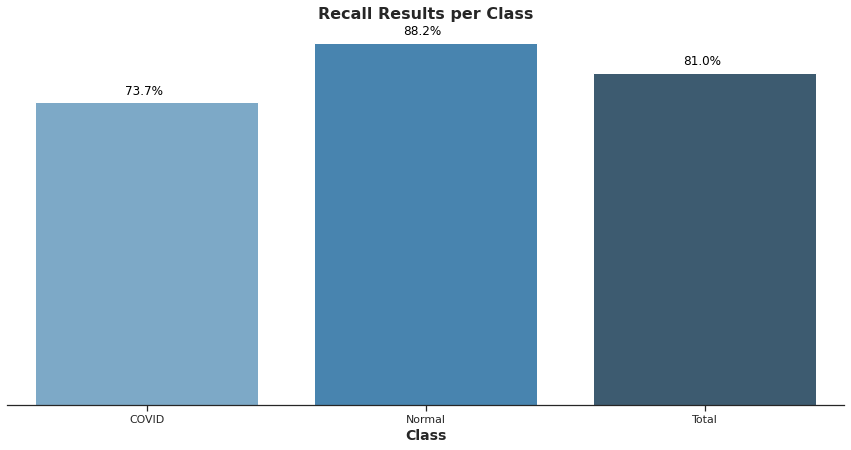

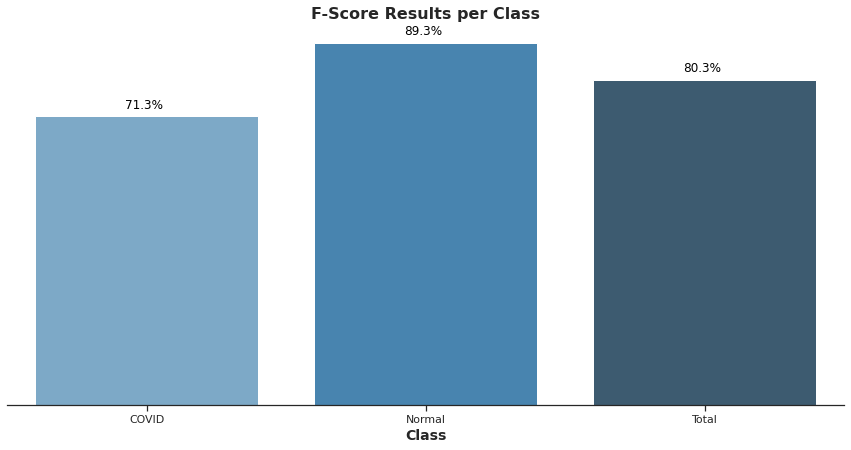

In [35]:
acc = accuracy_score(y_true, predictions)

results_all = precision_recall_fscore_support(y_true, predictions, average='macro', zero_division=1)
results_class = precision_recall_fscore_support(y_true, predictions, average=None, zero_division=1)

metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['COVID', 'Normal', 'Total']

def metrics_plot(df,metric):
    plt.figure(figsize=(15,7))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');

metrics_plot(all_df, 'Precision')#Results by Class
metrics_plot(all_df, 'Recall')#Results by Class
metrics_plot(all_df, 'F-Score')#Results by Class
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[2,0]*100))#Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[2,1]*100))#Recall of the whole Dataset
print('F-Score Result: %.2f%%'%(all_df.iloc[2,2]*100))#F-Score of the whole Dataset